In [1]:
import mxnet as mx

from mxnet.symbol import Convolution, Activation, Pooling, Dropout, FullyConnected, var, flatten, SoftmaxOutput

import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
mnist = mx.test_utils.get_mnist()

INFO:root:train-labels-idx1-ubyte.gz exists, skipping download
INFO:root:train-images-idx3-ubyte.gz exists, skipping download
INFO:root:t10k-labels-idx1-ubyte.gz exists, skipping download
INFO:root:t10k-images-idx3-ubyte.gz exists, skipping download


In [8]:
batch_size = 128

train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist["train_label"], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist["test_label"], batch_size, shuffle=True)

In [4]:
def conv_layer(x, num_filter):
    
    x = Convolution(data=x, kernel=(5,5), num_filter=num_filter)
    x = Activation(data=x, act_type="tanh")
    x = Pooling(data=x, pool_type="max", kernel=(2,2), stride=(2,2))

    return x


def full_layers(x, architecture, act_type="tanh", p=None):
    
    for num_cell in architecture:
        x = FullyConnected(x, num_hidden=num_cell)
        if p is not None:
            x = Dropout(x, p=p)
        x = Activation(x, act_type=act_type)

    return x


def generate_lenet(dropout=None, act_type="tanh", full_geom=[500]):
    
    data = var("data")
    
    x = conv_layer(data, 20)
    x = conv_layer(x, 50)
    x = flatten(x)
    x = full_layers(x, full_geom, act_type=act_type, p=dropout)
    x = FullyConnected(data=x, num_hidden=10)
    x = SoftmaxOutput(data=x, name="softmax")
    
    return x, data

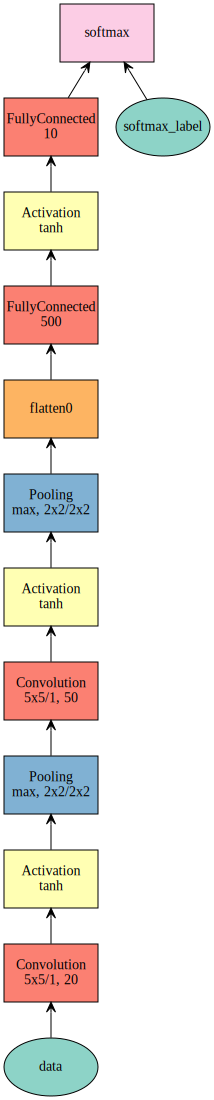

In [5]:
lenet, data = generate_lenet()

mx.viz.plot_network(lenet)

## Lenet with sgd

In [6]:
%%time

# create a trainable module on GPU 0
lenet_model = mx.mod.Module(symbol=lenet, context=mx.gpu())
# train with the same
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.01, 'momentum':0.97},
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=25)

INFO:root:Epoch[0] Train-accuracy=0.286031
INFO:root:Epoch[0] Time cost=2.253
INFO:root:Epoch[0] Validation-accuracy=0.893493
INFO:root:Epoch[1] Train-accuracy=0.953092
INFO:root:Epoch[1] Time cost=2.175
INFO:root:Epoch[1] Validation-accuracy=0.974486
INFO:root:Epoch[2] Train-accuracy=0.978878
INFO:root:Epoch[2] Time cost=2.323
INFO:root:Epoch[2] Validation-accuracy=0.983782
INFO:root:Epoch[3] Train-accuracy=0.985175
INFO:root:Epoch[3] Time cost=2.167
INFO:root:Epoch[3] Validation-accuracy=0.986946
INFO:root:Epoch[4] Train-accuracy=0.988356
INFO:root:Epoch[4] Time cost=2.087
INFO:root:Epoch[4] Validation-accuracy=0.986847
INFO:root:Epoch[5] Train-accuracy=0.991171
INFO:root:Epoch[5] Time cost=2.057
INFO:root:Epoch[5] Validation-accuracy=0.987737
INFO:root:Epoch[6] Train-accuracy=0.993887
INFO:root:Epoch[6] Time cost=2.024
INFO:root:Epoch[6] Validation-accuracy=0.989320
INFO:root:Epoch[7] Train-accuracy=0.995003
INFO:root:Epoch[7] Time cost=2.047
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 1min 9s, sys: 8.34 s, total: 1min 17s
Wall time: 57.3 s


## Lenet with adagrad

In [7]:
%%time

# create a trainable module on GPU 0
lenet_model = mx.mod.Module(symbol=lenet, context=mx.gpu())
# train with the same
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='adagrad',
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=25)

INFO:root:Epoch[0] Train-accuracy=0.916811
INFO:root:Epoch[0] Time cost=2.290
INFO:root:Epoch[0] Validation-accuracy=0.974189
INFO:root:Epoch[1] Train-accuracy=0.976896
INFO:root:Epoch[1] Time cost=2.253
INFO:root:Epoch[1] Validation-accuracy=0.981309
INFO:root:Epoch[2] Train-accuracy=0.982976
INFO:root:Epoch[2] Time cost=2.274
INFO:root:Epoch[2] Validation-accuracy=0.984869
INFO:root:Epoch[3] Train-accuracy=0.986474
INFO:root:Epoch[3] Time cost=2.262
INFO:root:Epoch[3] Validation-accuracy=0.986650
INFO:root:Epoch[4] Train-accuracy=0.989172
INFO:root:Epoch[4] Time cost=2.263
INFO:root:Epoch[4] Validation-accuracy=0.988430
INFO:root:Epoch[5] Train-accuracy=0.990938
INFO:root:Epoch[5] Time cost=2.258
INFO:root:Epoch[5] Validation-accuracy=0.988924
INFO:root:Epoch[6] Train-accuracy=0.992287
INFO:root:Epoch[6] Time cost=2.256
INFO:root:Epoch[6] Validation-accuracy=0.989221
INFO:root:Epoch[7] Train-accuracy=0.993354
INFO:root:Epoch[7] Time cost=2.300
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 2min 17s, sys: 11.5 s, total: 2min 28s
Wall time: 1min 3s


## Lenet2 with sgd

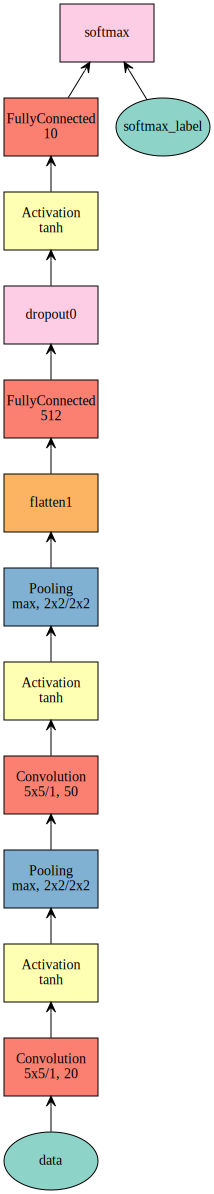

In [6]:
lenet2,data2 = generate_lenet(dropout=0.7, full_geom=[512])

mx.viz.plot_network(lenet2)

In [9]:
%%time

lenet_model = mx.mod.Module(symbol=lenet2, context=mx.gpu())

lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.01, 'momentum':0.9},
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=40)

INFO:root:Epoch[0] Train-accuracy=0.111874
INFO:root:Epoch[0] Time cost=2.043
INFO:root:Epoch[0] Validation-accuracy=0.113726
INFO:root:Epoch[1] Train-accuracy=0.491954
INFO:root:Epoch[1] Time cost=2.119
INFO:root:Epoch[1] Validation-accuracy=0.901108
INFO:root:Epoch[2] Train-accuracy=0.931203
INFO:root:Epoch[2] Time cost=2.026
INFO:root:Epoch[2] Validation-accuracy=0.955400
INFO:root:Epoch[3] Train-accuracy=0.961037
INFO:root:Epoch[3] Time cost=2.053
INFO:root:Epoch[3] Validation-accuracy=0.970926
INFO:root:Epoch[4] Train-accuracy=0.970899
INFO:root:Epoch[4] Time cost=2.048
INFO:root:Epoch[4] Validation-accuracy=0.977255
INFO:root:Epoch[5] Train-accuracy=0.976213
INFO:root:Epoch[5] Time cost=2.083
INFO:root:Epoch[5] Validation-accuracy=0.980320
INFO:root:Epoch[6] Train-accuracy=0.979861
INFO:root:Epoch[6] Time cost=2.099
INFO:root:Epoch[6] Validation-accuracy=0.982397
INFO:root:Epoch[7] Train-accuracy=0.982309
INFO:root:Epoch[7] Time cost=2.149
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 1min 52s, sys: 12.4 s, total: 2min 4s
Wall time: 1min 31s


In [14]:
%%time

lenet_model = mx.mod.Module(symbol=lenet2, context=mx.gpu())

lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.0316, 'momentum':0.954},
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=40)

INFO:root:Epoch[0] Train-accuracy=0.104226
INFO:root:Epoch[0] Time cost=0.620
INFO:root:Epoch[0] Validation-accuracy=0.101167
INFO:root:Epoch[1] Train-accuracy=0.835888
INFO:root:Epoch[1] Time cost=2.069
INFO:root:Epoch[1] Validation-accuracy=0.969640
INFO:root:Epoch[2] Train-accuracy=0.963386
INFO:root:Epoch[2] Time cost=2.052
INFO:root:Epoch[2] Validation-accuracy=0.980222
INFO:root:Epoch[3] Train-accuracy=0.973331
INFO:root:Epoch[3] Time cost=2.056
INFO:root:Epoch[3] Validation-accuracy=0.984968
INFO:root:Epoch[4] Train-accuracy=0.977679
INFO:root:Epoch[4] Time cost=2.059
INFO:root:Epoch[4] Validation-accuracy=0.987935
INFO:root:Epoch[5] Train-accuracy=0.979361
INFO:root:Epoch[5] Time cost=2.062
INFO:root:Epoch[5] Validation-accuracy=0.987243
INFO:root:Epoch[6] Train-accuracy=0.982393
INFO:root:Epoch[6] Time cost=2.053
INFO:root:Epoch[6] Validation-accuracy=0.987836
INFO:root:Epoch[7] Train-accuracy=0.983609
INFO:root:Epoch[7] Time cost=2.051
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 1min 51s, sys: 12.5 s, total: 2min 3s
Wall time: 1min 27s


In [15]:
%%time

lenet_model = mx.mod.Module(symbol=lenet2, context=mx.gpu())

lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='adagrad',
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=40)

INFO:root:Epoch[0] Train-accuracy=0.933402
INFO:root:Epoch[0] Time cost=2.326
INFO:root:Epoch[0] Validation-accuracy=0.975969
INFO:root:Epoch[1] Train-accuracy=0.976879
INFO:root:Epoch[1] Time cost=2.296
INFO:root:Epoch[1] Validation-accuracy=0.981804
INFO:root:Epoch[2] Train-accuracy=0.981893
INFO:root:Epoch[2] Time cost=2.314
INFO:root:Epoch[2] Validation-accuracy=0.984771
INFO:root:Epoch[3] Train-accuracy=0.985591
INFO:root:Epoch[3] Time cost=2.291
INFO:root:Epoch[3] Validation-accuracy=0.986452
INFO:root:Epoch[4] Train-accuracy=0.986890
INFO:root:Epoch[4] Time cost=2.302
INFO:root:Epoch[4] Validation-accuracy=0.988331
INFO:root:Epoch[5] Train-accuracy=0.988140
INFO:root:Epoch[5] Time cost=2.315
INFO:root:Epoch[5] Validation-accuracy=0.988133
INFO:root:Epoch[6] Train-accuracy=0.990172
INFO:root:Epoch[6] Time cost=2.293
INFO:root:Epoch[6] Validation-accuracy=0.988924
INFO:root:Epoch[7] Train-accuracy=0.990772
INFO:root:Epoch[7] Time cost=2.305
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 3min 37s, sys: 18.9 s, total: 3min 56s
Wall time: 1min 39s


In [24]:
#test_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)
acc = mx.metric.Accuracy()
lenet_model.score(test_iter, acc)
rslt = acc.get()[1]

rslt

0.99139636075949367